In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import math
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Additional Commands to Run:
# pip install cartopy
# pip uninstall shapely
# pip install shapely --no-binary shapely

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# POWER DISTRUBTION MODEL FUNCTIONS

# takes in coordinates for hurricane eye, transmission pole 'A' and 'B' in a list/array of the form (x,y)
# returns minimum distance, maximum distance
def dminmax(eye, A, B):
  a, b, c = distance(eye[0], eye[1], B[0], B[1]), distance(A[0], A[1], eye[0], eye[1]), distance(A[0], A[1], B[0], B[1])
  s = (a+b+c)/2.0
  Area = math.sqrt(s*(s-a)*(s-b)*(s-c))
  d_min = (2*Area)/c
  if a>=b:
    d_max = a
  else:
    d_max = b
  return d_min, d_max

# implements Hurricane Impact Matrix using coordinates for dminmax() function...
# and variables to generate gradient wind field function passed in the form m_h = [r_mw, r_s, w_m]
# i.e. each hurricane j is defined in the HIM by its m_h values
def HIM(eye, transpostA, transpostB, m_h):
  r_mw, r_s, w_m = m_h[:]
  d_min, d_max = dminmax(eye, transpostA, transpostB)
  if d_min<=r_mw<=d_max:
    windspeed = w_m
  else:
    windspeed = max(w(d_min, r_mw, r_s, w_m), w(d_max, r_mw, r_s, w_m))
  return windspeed

# INITIAL PARAMETERS #

# radius of maximum wind (km)
rmw = 28.5
# maximum sustained wind (m/s)
wm = 75
# radius of smallest wind (km)
rs = 400
B = 10
K = 1.14
α = 0.04

Ξ = K * wm
Ψ = 1/(rmw)*math.log(K/(K-1))

# x and y coordinates of the eye of the hurricane
eyeX = -95.2
eyeY = 28.9

# read in data and reduce columns
busdata_raw = pd.read_csv('/content/drive/My Drive/WSU Summer Internship/Texas2000busdata-BUS.txt', sep='\s+' )
busdata = busdata_raw[['BusNum', 'BusName', 'Latitude:1', 'Longitude:1']]
busdata['voltage'] = busdata_raw.drop_duplicates()['BusNomVolt']
busdata = busdata.set_index('BusNum')
busdata = busdata.append(pd.Series(name=np.NaN))

linedata_raw = pd.read_csv('/content/drive/My Drive/WSU Summer Internship/Texas2000busdata-LINES.txt', sep='\s+' )
linedata = linedata_raw[['BusNum','BusNum:1']]
linedata = linedata.drop_duplicates().reset_index().drop('index', axis=1 )
linedata['NaN'] = np.NaN

# 'pairs' organizes transmission lines into stacked DataFrame in the form:
# FROM BusNum
# TO BusNum:1
# NaN (to separate each pair)
pairs = linedata.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

longitudes = busdata['Longitude:1'][pairs[0][:]]
latitudes = busdata['Latitude:1'][pairs[0][:]]

# linedata['LineID']= linedata['BusNum'].astype(str) + '-' + linedata['BusNum:1'].astype(str)
# linedata.set_index('LineID')

linedata ['from(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum']],busdata['Latitude:1'][linedata['BusNum']]))
linedata ['to(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum:1']],busdata['Latitude:1'][linedata['BusNum:1']]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [29]:
busdata[:]['voltage']
volts = []
for i in linedata['BusNum']:
  volts.append(busdata['voltage'][i])
linedata['voltage'] = volts

# test
linedatatest = linedata[['BusNum','voltage']].copy().drop_duplicates()
linedatatest = linedatatest.set_index('BusNum')
for i in linedata ['BusNum']:
  if linedatatest['voltage'][i] != busdata['voltage'][i]:
    print('voltage ERROR', i)
    
# creates dataframes for each voltage level in grid
voltageI = linedata['voltage']
voltageI=[np.int16(x) for x in voltageI]
linedata['voltage']=voltageI

linedata_ByVoltage = [1,2,3,4]

voltageLevels = linedata['voltage'].unique()
for i in range(len(voltageLevels)):
  df = linedata[linedata['voltage']==voltageLevels[i]]
  linedata_ByVoltage[i] = df.filter(items=['BusNum', 'BusNum:1', 'NaN'])
linedata_115v = linedata_ByVoltage[0]
linedata_230v = linedata_ByVoltage[1]
linedata_500v = linedata_ByVoltage[2]
linedata_161v = linedata_ByVoltage[3]

pairs115 = linedata_115v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs230 = linedata_230v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs500 = linedata_500v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs161 = linedata_161v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

figlist = [pairs115, pairs230, pairs500, pairs161]
colors = ['Blue', 'Red', 'Purple', 'Green']

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


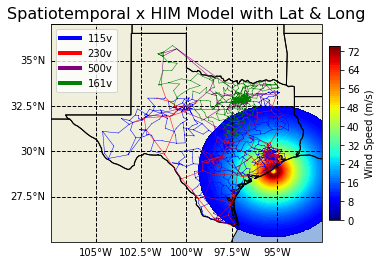

In [32]:
# Longitude: -107.5 to -92.5
# Latitude: 25.0 to 37.0
x1 = np.arange(-107.5,-92.5,0.05)
x2 = np.arange(25.0,37.0,0.05)
x1, x2 = np.meshgrid(x1, x2)

def landfall_wind_field(x1,x2):
  global rmw
  global wm
  global rs_path
  global B
  global K
  global Ξ
  global Ψ
  global eyeX
  global eyeY
  
  # revise x1 and x2 to account for the eye of the hurricane
  Olat = eyeY
  Olon = eyeX
  Dlat = x2
  Dlon = x1
  
  # Calculating distance to center
  d = 6371.  # km
  
  d_lat = np.radians(Dlat - Olat)
  d_lon = np.radians(Dlon - Olon)
  a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
       np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
       np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
  radius = d * c
  
  result = np.piecewise(radius, [(radius >= 0) & (radius < rmw), (radius >= rmw) & (radius <= rs), radius > rs], [lambda radius: (Ξ*(1 - np.exp(-1*Ψ*radius))), lambda radius: wm*np.exp(-1*(np.log(B)/(rs-rmw))*(radius-rmw)),lambda radius: -1])

  return result

def plot_data(result, index):    
    global x1
    global x2
    global latitudes
    global longitudes
    global figlist

    hours = index*2
    
    plt.figure(index)
    
    # Set the figure size, projection, and extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-107.5,-92.5,25.0,37.0])
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black')
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
    ax.coastlines(resolution="50m",linewidth=1)
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-107.5,-105.0,-102.5,-100.0,-97.5,-95.0,-92.5])
    gl.ylocator = mticker.FixedLocator([25,27.5,30.0,32.5,35.0,37.0])
    
    
    # Plot windspeed
    clevs = np.arange(0,75,1)
    plt.contourf(x1, x2, result, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    plt.title('Spatiotemporal x HIM Model with Lat & Long', size=16)
    cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
    cb.set_label('Wind Speed (m/s)',size=10,rotation=90,labelpad=5)
    cb.ax.tick_params(labelsize=10)

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]

    for count, i in enumerate(figlist):
      plt.plot(busdata['Longitude:1'][i[0][:]], busdata['Latitude:1'][i[0][:]], color=colors[count], linewidth=0.5)
    plt.legend(custom_lines, ['115v', '230v', '500v', '161v'])

result = landfall_wind_field(x1,x2)
plot_data(result, 0)